In [1]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
# import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax
import numpy.random as npr
import jax

import itertools
from functools import partial
# np = jax.numpy
# np = autograd.numpy

/auto/homes/fav25/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [123]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(0), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.momentum(step_size, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.momentum(step_size, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
        
    @staticmethod
    @partial(jit, static_argnums=(1,2, 5))
    def loss_for_trajectory(Xt, b_f, b_b, dt, theta, forwards):
        
        if not forwards : Xt = Xt[::-1, :]
        
        b_minus  = b_b(theta, Xt)
        b_plus = b_f(theta, Xt)
        
        delta_Xt = Xt[:-1, :]  - Xt[1:, :]
        
        sign = 1.0 if forwards else -1.0
        
        ito_integral = sign *  (b_plus[1:,:] - b_minus[:-1,:])  * delta_Xt
        
        time_integral = sign *  (b_plus**2 - b_minus**2) * dt # Not sure about this dt here
        
        return ito_integral.sum() - 0.5 * time_integral.sum()
        
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
    @staticmethod
    def sample_trajectory(X, dt, theta, sigma, b, N, sde_solver, forwards=True):
        return sde_solver(alfa=b, beta=sigma,
                          dt=dt, X0=X,
                          N=N, theta=theta)

    @staticmethod
#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(terminal_index, theta, batch, dt, 
                       batch_terminal_empirical, H , b_forward,
                       b_backward, sigma, N, sde_solver, forwards):
        
        b = (b_forward if forwards else (lambda X, theta: -b_backward(X, theta)))
        
        def inner_loss_loop(x):
            t, Xt = cIPFP.sample_trajectory(x, dt, theta,  sigma, b, N, sde_solver, forwards)
            cross_entropy = -log_kde_pdf_per_point(Xt[-1].reshape(-1,1), batch_terminal_empirical, H)
            main_term = cIPFP.loss_for_trajectory(Xt, b_forward, b_backward, dt, theta, forwards)
            return main_term + cross_entropy 
            
#         for x in batch:
#             t, Xt = cIPFP.sample_trajectory(x, dt, theta,  sigma, b, N, sde_solver, forwards)
            
#             cross_entropy = log_kde_pdf_per_point(Xt[terminal_index].reshape(-1,1), batch_terminal_empirical, H)
            
#             J += cIPFP.loss_for_trajectory(Xt, b_forward, b_backward, dt, theta, forwards)
            
#             J += cross_entropy
        
#         J /= len(batch)
        J = np.mean(jax.vmap(inner_loss_loop)(batch))
        J = np.squeeze(J)
#         J = J.block_until_ready() 
        return J
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        terminal_index = -1 if forwards else 0
        X_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            terminal_index, theta, batch, self.dt, 
            X_terminal_empirical, H , self.b_forward,
            self.b_backward, self.sigma, self.number_time_steps, self.sde_solver, forwards
        )

    @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        for i in range(IPFP_iterations):
                                               
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
                    print(_)
                    batch_b =  next(batches_b)
                    opt_state_b  = self.update(
                        next(itercount), opt_state_b, batch_b, False
                    )

                params = self.get_params_b(opt_state_b)
                lossb = self.inner_loss(params, batch_b, False)
                print(f"loss b {lossb}")
            loss_b.append(lossb)
                                               
            
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
                    print(_)
                    batch_f =  next(batches_f)
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, next(batches_f), True
                    )
                params = self.get_params_f(opt_state_f)
                lossf = self.inner_loss(params, batch_f, True)
                print(f"loss f {lossf}")
            loss_f.append(lossf)
         

        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
            

In [124]:
X1 = npr.randn(100).reshape(-1,1) - 5
X2 = npr.randn(100).reshape(-1,1) + 5

In [125]:
c = cIPFP(X1, X2,  number_time_steps=100, batch_size=50 , step_size = 0.0001)

In [126]:
 _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
opt_state_f = c.opt_init_f(init_params_f)


theta_f = c.get_params_f(opt_state_f)


In [127]:
theta_f[0][1].shape, theta_f[1]

((100,), ())

In [128]:
t, Xt = c.sample_trajectory(X1[0],c.dt,  theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver, True)

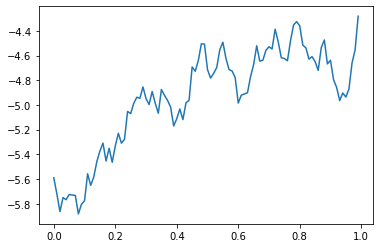

In [129]:
import matplotlib.pyplot as plt

plt.plot(t, Xt.flatten())

In [130]:
import numpy as onp
import jax.numpy as np

X0 = np.array(X1[0,:])
t0=0

alfa  = c.b_forward 
beta = c.sigma
randn = onp.random.randn
dt = c.dt
N= c.number_time_steps
theta = theta_f


if alfa is None or beta is None:
    raise ValueError("Error: SDE not defined.")


X0 = randn(*alfa(0, 0).shape) if X0 is None else np.array(X0)
#     DW = (lambda Y, dt: randn((len(X0))) * np.sqrt(dt)) if DW is None else DW
DWs  = randn(N-1, len(X0))  * np.sqrt(dt)



Y, ti = np.zeros((N, len(X0))), np.arange(N)*dt + t0
Y = jax.ops.index_update(Y, jax.ops.index[0,:],  X0)



In [131]:
loss= c.loss_for_trajectory(Xt, c.b_forward, c.b_backward, c.dt, theta_f, True)

In [132]:
cross_entropy = log_kde_pdf_per_point(Xt[-1].reshape(-1,1), X2, c.H_0)

In [133]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 197 ms, sys: 4.05 ms, total: 201 ms
Wall time: 189 ms


DeviceArray(143.66988, dtype=float32)

In [134]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 6.75 ms


DeviceArray(166.20569, dtype=float32)

In [102]:

# _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
# opt_state_f = c.opt_init_f(init_params_f)

# _, init_params_b = c.b_backward_init(c.rng, (-1, c.dim))                                               
# opt_state_b = c.opt_init_b(init_params_b)

# batches_f = c.data_stream(forward=True)
# batches_b = c.data_stream(forward=False)

# c.update(0, opt_state_b, next(batches_b), forwards=False)
                                       

In [103]:
from jax import grad


In [104]:
%%time
gradient = jit(grad(c.inner_loss), static_argnums=(2))
kek = gradient(theta_f, X1, True)
# partial(jit, static_argnums=(2))(gradient)

CPU times: user 2.75 s, sys: 7.99 ms, total: 2.76 s
Wall time: 2.76 s


In [105]:
%%time
kek = gradient(theta_f, X1, True)

CPU times: user 2.22 ms, sys: 5 µs, total: 2.23 ms
Wall time: 1.82 ms


0
1
loss b 136.24459838867188
0
1
loss f 176.20098876953125


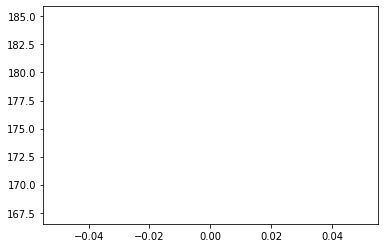

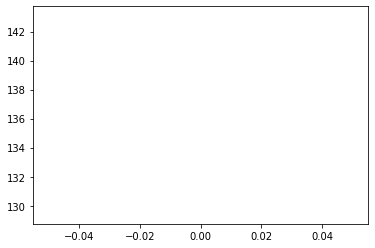

CPU times: user 13.1 s, sys: 59.7 ms, total: 13.1 s
Wall time: 13 s


In [135]:
%%time
c.fit(1,1)

0
1
loss b 140.14834594726562
0
1
loss f 116.77159881591797


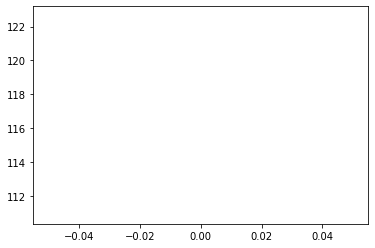

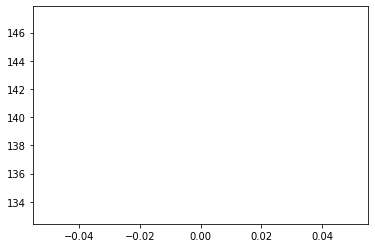

CPU times: user 430 ms, sys: 20.1 ms, total: 451 ms
Wall time: 407 ms


In [136]:
%%time
c.fit(1,1)

0
1
loss b 119.0283203125
0
1
loss b 112.42129516601562
0
1
loss b 90.10742950439453
0
1
loss b 82.80001068115234
0
1
loss b 68.31045532226562
0
1
loss b 39.082855224609375
0
1
loss b 31.096412658691406
0
1
loss b 38.39677429199219
0
1
loss b 37.13039016723633
0
1
loss b 33.714508056640625
0
1
loss b 21.948505401611328
0
1
loss b 42.02799987792969
0
1
loss b 27.942955017089844
0
1
loss b 32.9869499206543
0
1
loss b 29.337509155273438
0
1
loss b 30.737882614135742
0
1
loss b 30.586997985839844
0
1
loss b 29.585134506225586
0
1
loss b 20.379695892333984
0
1
loss b 27.06631851196289
0
1
loss b 37.62432861328125
0
1
loss b 23.89316177368164
0
1
loss b 24.233217239379883
0
1
loss b 31.316938400268555
0
1
loss b 33.21876907348633
0
1
loss b 33.740631103515625
0
1
loss b 25.107341766357422
0
1
loss b 33.003360748291016
0
1
loss b 35.10970687866211
0
1
loss b 35.594486236572266
0
1
loss f 160.32916259765625
0
1
loss f 167.9434356689453
0
1
loss f 112.23359680175781
0
1
loss f 69.00910186767578

loss f 2.897789239883423
0
1
loss f 4.659124851226807
0
1
loss f 1.968116044998169
0
1
loss f 4.837002754211426
0
1
loss f 7.425018787384033
0
1
loss f 2.639477252960205
0
1
loss f 4.323124885559082
0
1
loss f 9.08130168914795
0
1
loss f 4.136102676391602
0
1
loss f 1.6880306005477905
0
1
loss f 2.484347343444824
0
1
loss f 5.320695877075195
0
1
loss f 2.718029737472534
0
1
loss f 2.300480842590332
0
1
loss f 1.7409166097640991
0
1
loss f 3.448983669281006
0
1
loss f 16.896257400512695
0
1
loss f 2.368476629257202
0
1
loss f 1.2968244552612305
0
1
loss f 2.8304498195648193
0
1
loss b 3.4593071937561035
0
1
loss b 1.428971290588379
0
1
loss b 3.281024694442749
0
1
loss b 3.1808319091796875
0
1
loss b 2.9348013401031494
0
1
loss b 0.6104699969291687
0
1
loss b 2.3589794635772705
0
1
loss b 3.296830654144287
0
1
loss b 23.52599334716797
0
1
loss b 1.9645172357559204
0
1
loss b 10.358264923095703
0
1
loss b 1.4203765392303467
0
1
loss b 1.6892247200012207
0
1
loss b 1.6350271701812744
0
1


loss b 0.20670777559280396
0
1
loss b 6.587404251098633
0
1
loss b 0.05229583755135536
0
1
loss b 1.3102902173995972
0
1
loss b 4.359845161437988
0
1
loss b 5.848604202270508
0
1
loss b 3.170377731323242
0
1
loss b 0.11956071108579636
0
1
loss b 1.9900075197219849
0
1
loss b 2.27548885345459
0
1
loss b 1.0012767314910889
0
1
loss b 0.1365976184606552
0
1
loss b 0.2573511600494385
0
1
loss b 0.43430763483047485
0
1
loss f 0.5593746304512024
0
1
loss f 0.502357006072998
0
1
loss f 1.6677366495132446
0
1
loss f 0.8746237754821777
0
1
loss f 1.4420256614685059
0
1
loss f 7.694508075714111
0
1
loss f 0.3893852233886719
0
1
loss f 3.138749361038208
0
1
loss f 1.840464472770691
0
1
loss f 1.7649551630020142
0
1
loss f 1.485068678855896
0
1
loss f 4.1398024559021
0
1
loss f 4.1243672370910645
0
1
loss f 1.7976067066192627
0
1
loss f 12.13014030456543
0
1
loss f 3.3809280395507812
0
1
loss f 0.6570677161216736
0
1
loss f 0.4731525480747223
0
1
loss f 0.40848785638809204
0
1
loss f 0.95264142751

loss f 0.027427108958363533
0
1
loss f 1.4596831798553467
0
1
loss f 0.5154955387115479
0
1
loss f 0.9046914577484131
0
1
loss f 5.5169548988342285
0
1
loss f 1.335898756980896
0
1
loss f 0.5866958498954773
0
1
loss b -0.0664951354265213
0
1
loss b 1.924607276916504
0
1
loss b 0.136741042137146
0
1
loss b 1.6383854150772095
0
1
loss b 0.5929029583930969
0
1
loss b -0.23830850422382355
0
1
loss b 1.7935906648635864
0
1
loss b 0.39697718620300293
0
1
loss b -0.08508485555648804
0
1
loss b 0.8152556419372559
0
1
loss b -0.034197282046079636
0
1
loss b 0.08524773269891739
0
1
loss b 1.595436692237854
0
1
loss b 0.26976555585861206
0
1
loss b 0.6015365123748779
0
1
loss b 2.0250844955444336
0
1
loss b 1.1009200811386108
0
1
loss b 4.674880504608154
0
1
loss b 1.6788181066513062
0
1
loss b 1.912656545639038
0
1
loss b 0.007794297765940428
0
1
loss b 2.395393133163452
0
1
loss b 0.18559938669204712
0
1
loss b 0.19937105476856232
0
1
loss b 0.4255981743335724
0
1
loss b 0.04172568395733833
0
1

loss b 0.1393199861049652
0
1
loss b -0.07112053036689758
0
1
loss b 0.5339494943618774
0
1
loss b 2.114032745361328
0
1
loss f 0.3626989722251892
0
1
loss f 0.7530127763748169
0
1
loss f 2.154958486557007
0
1
loss f 0.6265157461166382
0
1
loss f 1.0319182872772217
0
1
loss f 0.7697547674179077
0
1
loss f 0.8888295888900757
0
1
loss f 2.6217381954193115
0
1
loss f 0.5817481875419617
0
1
loss f 1.821962833404541
0
1
loss f 0.567854642868042
0
1
loss f 0.4304690659046173
0
1
loss f 4.039716720581055
0
1
loss f 0.6391055583953857
0
1
loss f 0.578886866569519
0
1
loss f 0.4222078025341034
0
1
loss f 0.42930150032043457
0
1
loss f 3.8896284103393555
0
1
loss f 9.649044036865234
0
1
loss f 1.1627392768859863
0
1
loss f 0.49267804622650146
0
1
loss f 3.0848937034606934
0
1
loss f 0.2661796510219574
0
1
loss f 4.271651268005371
0
1
loss f 1.273513674736023
0
1
loss f 0.4148019552230835
0
1
loss f 1.5506036281585693
0
1
loss f 0.8347631692886353
0
1
loss f 10.919882774353027
0
1
loss f 3.811474

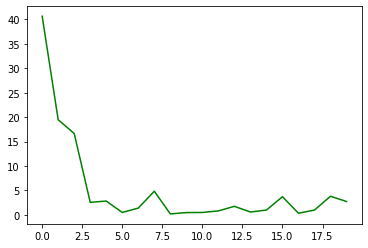

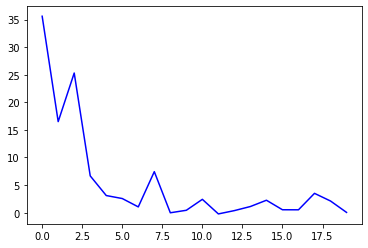

In [137]:
c.fit(20,30)